In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing Necessary Libraries**

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc

**Defining Dataset Path**

In [9]:
# Define the path to the 'real_hst' dataset directory
dataset_dir = '/content/drive/MyDrive/real_hst'

**Loading the Data**

In [10]:
# Function to load data and labels
def load_data(data_dir):
    data = []
    labels = []
    for label_name in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label_name)
        for filename in os.listdir(label_dir):
            img_path = os.path.join(label_dir, filename)
            img = np.load(img_path)  # Load the image
            data.append(img)
            labels.append(label_name)
    return np.array(data), np.array(labels)

**Loading and Preprocessing Data**

In [11]:
# Load and preprocess the data
train_data, train_labels = load_data(os.path.join(dataset_dir, 'train'))
val_data, val_labels = load_data(os.path.join(dataset_dir, 'val'))

**Converting string label to numerical labels**

In [12]:
# Convert string labels to numerical labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)

**Converting Numerical lebels to Categorical Format**

In [13]:
# Convert numerical labels to categorical format
num_classes = len(np.unique(train_labels))
train_labels_categorical = tf.keras.utils.to_categorical(train_labels_encoded, num_classes)
val_labels_categorical = tf.keras.utils.to_categorical(val_labels_encoded, num_classes)

**Defining the Model Architecture**

In [14]:
# Define the SimCLR model architecture
def get_simclr_model(input_shape, num_classes, projection_dim=128):
    inputs = Input(shape=input_shape)
    x = tf.expand_dims(inputs, axis=-1)  # Add channel dimension for grayscale images
    x = GlobalAveragePooling2D()(x)
    x = Dense(projection_dim, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create SimCLR model
    simclr_model = Model(inputs, outputs)

    return simclr_model

# Define input shape
input_shape = train_data.shape[1:]

# Create SimCLR model
simclr_model = get_simclr_model(input_shape, num_classes)

# Compile the SimCLR model
simclr_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

**Display Images before training**

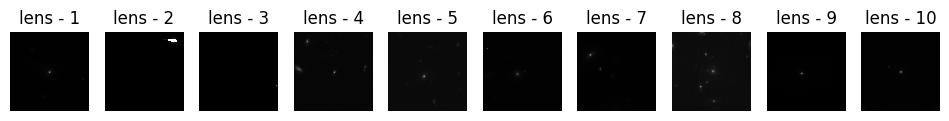

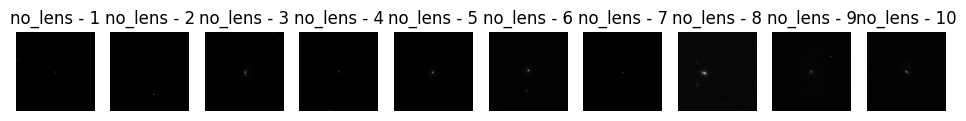

In [15]:
# Display 10 images from 'lens' and 'no_lens' folders before training
class_names = ['lens', 'no_lens']
for class_name in class_names:
    display_images(os.path.join(dataset_dir, 'train'), class_name, num_images=10)

**Train the model**

In [16]:
history = simclr_model.fit(train_data, train_labels_categorical, epochs=10, batch_size=32, validation_data=(val_data, val_labels_categorical))

Epoch 1/10
8/8 [==============================] - 2s 165ms/step - loss: nan - accuracy: 0.8465 - val_loss: nan - val_accuracy: 0.7391
Epoch 2/10
8/8 [==============================] - 0s 18ms/step - loss: nan - accuracy: 0.8465 - val_loss: nan - val_accuracy: 0.7391
Epoch 3/10
8/8 [==============================] - 0s 20ms/step - loss: nan - accuracy: 0.8465 - val_loss: nan - val_accuracy: 0.7391
Epoch 4/10
8/8 [==============================] - 0s 34ms/step - loss: nan - accuracy: 0.8465 - val_loss: nan - val_accuracy: 0.7391
Epoch 5/10
8/8 [==============================] - 0s 12ms/step - loss: nan - accuracy: 0.8465 - val_loss: nan - val_accuracy: 0.7391
Epoch 6/10
8/8 [==============================] - 0s 10ms/step - loss: nan - accuracy: 0.8465 - val_loss: nan - val_accuracy: 0.7391
Epoch 7/10
8/8 [==============================] - 0s 10ms/step - loss: nan - accuracy: 0.8465 - val_loss: nan - val_accuracy: 0.7391
Epoch 8/10
8/8 [==============================] - 0s 10ms/step - los

**Evaluation of model on training and validation sets**

In [17]:
# Evaluate the model on training and validation sets
train_loss, train_accuracy = simclr_model.evaluate(train_data, train_labels_categorical, verbose=0)
val_loss, val_accuracy = simclr_model.evaluate(val_data, val_labels_categorical, verbose=0)

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Train Accuracy: 84.65%
Validation Accuracy: 73.91%


**Displaying Images after Training**

In [18]:
# Load the trained model
trained_model = simclr_model

# Function to display images after training
def display_images_after_training(model, data_dir, class_name, num_images=10):
    class_folder = os.path.join(data_dir, class_name)
    image_files = os.listdir(class_folder)
    num_images = min(num_images, len(image_files))
    selected_images = np.random.choice(image_files, num_images, replace=False)

    plt.figure(figsize=(12, 6))
    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(class_folder, image_file)
        img = np.load(image_path)
        img = np.expand_dims(img, axis=0)  # Add batch dimension
        prediction = model.predict(img)  # Get model prediction
        predicted_class = np.argmax(prediction)  # Get predicted class index

        plt.subplot(2, num_images, i + 1)
        plt.imshow(img.squeeze(), cmap='gray')  # Assuming grayscale images
        plt.title(f'{class_name} - {i+1}\nPredicted: {label_encoder.classes_[predicted_class]}')
        plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 15ms/step


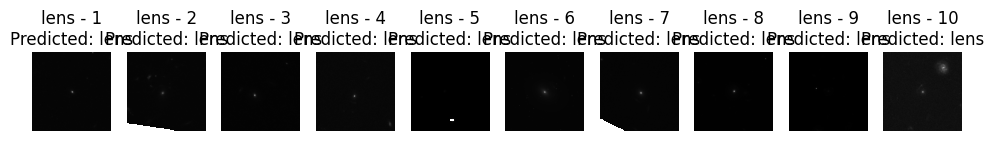

1/1 [==============================] - 0s 13ms/step


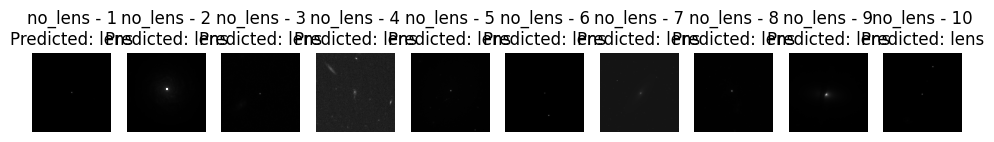

In [19]:
# Display 10 images from 'lens' and 'no_lens' folders after training
for class_name in class_names:
    display_images_after_training(trained_model, os.path.join(dataset_dir, 'train'), class_name, num_images=10)

**Plotting Training and Validation Accuracy**

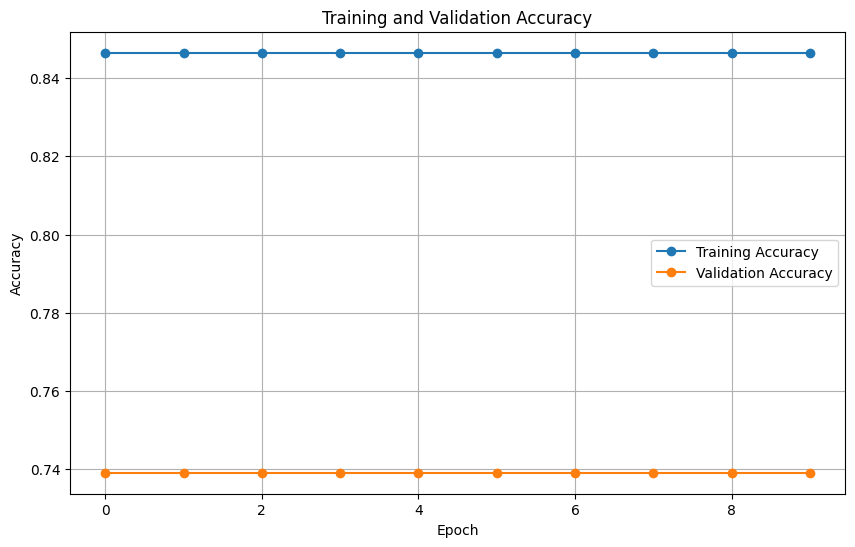

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()